<a href="https://colab.research.google.com/github/slvrsrfrrr/Machine-Learning/blob/main/Product_Grouping_based_on_Customer_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install openpyxl

In [4]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
from tqdm import trange

df = pd.read_excel('Online Retail.xlsx')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


simple algorithm to check where missing values are

In [5]:
columns_with_missing_values = df.columns[df.isnull().any()]

# Print columns with missing values
for column in columns_with_missing_values:
    print(f"Column '{column}' has missing values.")

Column 'Description' has missing values.
Column 'CustomerID' has missing values.


In [6]:
df['CustomerID'] = df['CustomerID'].fillna(-1).astype(int).astype('str').replace('-1', 'Unknown')
df['Description'] = df['Description'].str.strip()
df['On Credit'] = df['InvoiceNo'].str.contains('C')
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['ItemTotal'] = df['Quantity'] * df['UnitPrice']

we just got rid of the missing values in Customer ID.
then we reformatted the descriptions.
then created a new column called on credit.
next, the invoice data was converted to actual date type.
and finally, a new column was created that represented the total sum spent on a particular item, because people usually bought more than one.

In [7]:
df['UnitPrice'].describe()

count    541909.000000
mean          4.611114
std          96.759853
min      -11062.060000
25%           1.250000
50%           2.080000
75%           4.130000
max       38970.000000
Name: UnitPrice, dtype: float64

for Unit Price below 0, this implies returns so we're going to get rid of those, a well as unknown customers, for the sake of simplicity.

In [8]:
df = df[(df['CustomerID'] != 'Unknown') & (df['UnitPrice'] > 0)].reset_index(drop=True).copy()
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,On Credit,ItemTotal
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,NaN,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,NaN,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,NaN,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,NaN,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,NaN,20.34


Next, we extract the product feed.

In [9]:
feed_df = df.groupby(['StockCode', 'Country', ]).agg({'Description': 'first', 'UnitPrice': 'mean'}).reset_index().copy()
feed_df.head()

,StockCode,Country,Description,UnitPrice
0,10002,EIRE,INFLATABLE POLITICAL GLOBE,0.85
1,10002,France,INFLATABLE POLITICAL GLOBE,0.85
2,10002,Germany,INFLATABLE POLITICAL GLOBE,0.85
3,10002,Japan,INFLATABLE POLITICAL GLOBE,0.85
4,10002,Spain,INFLATABLE POLITICAL GLOBE,0.85


Here we extract invoices.

In [10]:
invoices_df = df.groupby(['InvoiceNo']).agg(
    {
        'StockCode': 'nunique',
        'Quantity': 'sum',
        'UnitPrice': ['mean', 'max', 'min'],
        'ItemTotal': 'sum'
    }
)
invoices_df.columns = ['_'.join(col).strip()
                       for col in invoices_df.columns.values]

# Discarding Outliers
[lv, uv] = invoices_df['Quantity_sum'].quantile([0.05, 0.95]).values

invoices_df = invoices_df[(invoices_df['Quantity_sum'] >= lv) & (
    invoices_df['Quantity_sum'] <= uv)].reset_index().copy()
invoices_df.head()

,InvoiceNo,StockCode_nunique,Quantity_sum,UnitPrice_mean,UnitPrice_max,UnitPrice_min,ItemTotal_sum
0,536365,7,40,3.910000,7.65,2.55,139.12
1,536366,2,12,1.850000,1.85,1.85,22.20
2,536367,12,83,4.853333,9.95,1.65,278.73
3,536368,4,15,4.775000,4.95,4.25,70.05
4,536369,1,3,5.950000,5.95,5.95,17.85


Here, we create a customer feature set.

In [11]:
customer_df = df.sort_values('InvoiceDate').groupby('CustomerID').agg(
    {
        'InvoiceDate': ['first', 'last'],
        'InvoiceNo': 'nunique',
        'Quantity': 'sum',
        'UnitPrice': 'mean',
    }
)

customer_df.columns = ['FirstPurchaseDate', 'LastPurchaseDate',
                       'TotalOrders', 'TotalQuantity', 'AveragePurchasePrice']

customer_df['DaysToDate'] = (
    customer_df['LastPurchaseDate'] - customer_df['FirstPurchaseDate']).dt.days + 1


# Ignoring one off customers
customer_df = customer_df[customer_df['DaysToDate'] > 1].copy()

customer_df.head()

,FirstPurchaseDate,LastPurchaseDate,TotalOrders,TotalQuantity,AveragePurchasePrice,DaysToDate
CustomerID,,,,,,
12347,2010-12-07 14:57:00,2011-12-07 15:52:00,7,2458,2.644011,366
12348,2010-12-16 19:09:00,2011-09-25 13:13:00,4,2341,5.764839,283
12352,2011-02-16 12:33:00,2011-11-03 14:37:00,11,470,23.274737,261
12356,2011-01-18 09:50:00,2011-11-17 08:40:00,3,1591,3.201186,303
12358,2011-07-12 10:04:00,2011-12-08 10:26:00,2,248,8.274211,150


we merge customer and invoice data.

In [12]:
invoices_df = invoices_df.merge(
    df[['CustomerID', 'InvoiceNo']],
    on='InvoiceNo'
)

invoices_df = invoices_df.groupby('CustomerID').agg(
    {
        'InvoiceNo': 'nunique',
        'StockCode_nunique': 'sum',
        'Quantity_sum': 'sum',
        'UnitPrice_mean': 'mean',
        'UnitPrice_max': 'mean',
        'UnitPrice_min': 'mean',
        'ItemTotal_sum': 'mean',
    }
)


customer_df = customer_df.merge(invoices_df, left_index=True, right_index=True)
customer_df['PurchaseFrequency'] = customer_df['TotalOrders'] / \
    customer_df['DaysToDate']

customer_df['AverageInvoiceItems'] = customer_df['TotalQuantity'] / \
    customer_df['TotalOrders']

customer_df = customer_df[customer_df['TotalQuantity'] > 0].copy()

customer_df.drop(columns=['FirstPurchaseDate',
                 'LastPurchaseDate'], inplace=True)
customer_df.head()

,TotalOrders,TotalQuantity,AveragePurchasePrice,DaysToDate,InvoiceNo,StockCode_nunique,Quantity_sum,UnitPrice_mean,UnitPrice_max,UnitPrice_min,ItemTotal_sum,PurchaseFrequency,AverageInvoiceItems
CustomerID,,,,,,,,,,,,,
12347,7,2458,2.644011,366,7,5516,74122,2.644011,10.669945,0.440604,737.259560,0.019126,351.142857
12348,4,2341,5.764839,283,3,70,5602,9.222143,40.000000,0.695714,294.974286,0.014134,585.250000
12352,11,470,23.274737,261,10,1114,7044,24.936477,53.318182,15.799432,267.124432,0.042146,42.727273
12356,3,1591,3.201186,303,2,445,7780,3.247391,12.750000,1.454348,444.667826,0.009901,530.333333
12358,2,248,8.274211,150,2,193,2236,8.274211,40.000000,0.933158,557.932632,0.013333,124.000000


we scale data, and find optimal clusters.

100%|██████████| 14/14 [00:01<00:00, 11.46it/s]


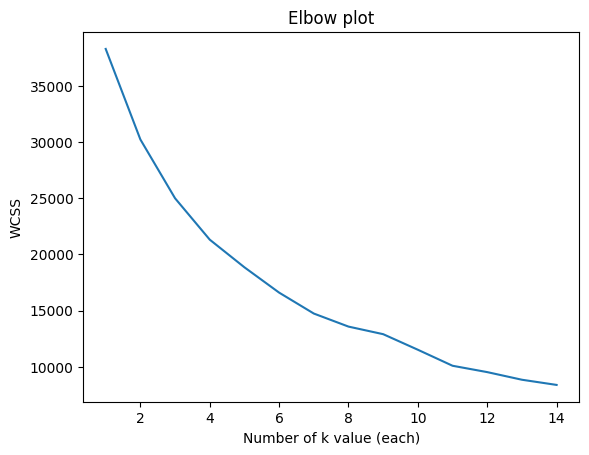

In [13]:
scaler = StandardScaler()

cdf = scaler.fit_transform(customer_df)
wcss = []

for each in trange(1, 15):
    kmeans = KMeans(n_clusters=each, n_init='auto', max_iter=1000, random_state=42)
    kmeans.fit(cdf)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 15), wcss)
plt.title('Elbow plot')
plt.xlabel("Number of k value (each)")
plt.ylabel("WCSS")
plt.show()

In [14]:
n_clusers = 6
model = KMeans(
    n_clusters=n_clusers,
    n_init='auto',
    max_iter=1000,
    random_state=42
)
cluster_k = model.fit_predict(cdf)


with_km_df = pd.DataFrame(
    cdf, columns=customer_df.columns, index=customer_df.index)
with_km_df['cluster'] = cluster_k
with_km_df['cluster'].value_counts(ascending=True)

1       1
2       3
4       5
5     108
3    1303
0    1525
Name: cluster, dtype: int64

now, we map products to clusters.

In [15]:
customer_df = customer_df.merge(
    with_km_df['cluster'], left_index=True, right_index=True).reset_index()

clustered_products_df = df.merge(customer_df[['CustomerID', 'cluster']], on='CustomerID')[
    ['StockCode', 'cluster']].drop_duplicates()
feed_df = feed_df.merge(clustered_products_df)

print(feed_df[['StockCode', 'cluster']].drop_duplicates()['cluster'].value_counts())
feed_df.head()

0    3501
3    3174
5    3047
2    2625
1     260
4     194
Name: cluster, dtype: int64


,StockCode,Country,Description,UnitPrice,cluster
0,10002,EIRE,INFLATABLE POLITICAL GLOBE,0.85,0
1,10002,EIRE,INFLATABLE POLITICAL GLOBE,0.85,2
2,10002,EIRE,INFLATABLE POLITICAL GLOBE,0.85,5
3,10002,EIRE,INFLATABLE POLITICAL GLOBE,0.85,3
4,10002,France,INFLATABLE POLITICAL GLOBE,0.85,0


visualise product attributes

In [16]:
rows= []
for i in range(n_clusers):
    rows.append([i] + feed_df[feed_df['cluster'] == i].UnitPrice.quantile(
        [0.05, .25, .5, .75, 0.95]).values.tolist())

pdf = pd.DataFrame(rows, columns=['cluster', '5%', '25%', '50%', '75%', '95%'])

pdf

,cluster,5%,25%,50%,75%,95%
0,0,0.417472,0.920267,1.85,3.75,9.709666
1,1,0.420000,1.250000,2.08,3.75,9.950000
2,2,0.419035,0.877944,1.79,3.75,8.950000
3,3,0.417797,0.908000,1.79,3.75,9.715440
4,4,0.390000,1.250000,2.08,4.15,10.950000
5,5,0.417388,0.861038,1.69,3.75,9.137467


customer to product mappings

In [17]:
k_customers_df = with_km_df['cluster'].value_counts().to_frame('Customers')
k_feed_df = feed_df[['StockCode', 'cluster']].drop_duplicates().groupby('cluster').size().to_frame('Products')
c2p_df = k_customers_df.merge(k_feed_df, left_index=True, right_index=True)

c2p_df.sort_index()

,Customers,Products
0,1525,3501
1,1,260
2,3,2625
3,1303,3174
4,5,194
5,108,3047


What we observe is that the clusters 0, 3, 5 are of major importance as they cater to majority of customers with a substantial product base. whereas the clusters 4, 2 and 1 can be considered ignorable cohorts. reclustering with a smaller number of clusters can also be done, but that may increase overlap of products between customer cohorts.